In [1]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

from tqdm import tqdm
from wordcloud import WordCloud

import nltk
from nltk import word_tokenize
nltk.download('punkt')

from gensim import corpora
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.matutils import corpus2dense, corpus2csc

import pyLDAvis
import pyLDAvis.lda_model

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\garim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Latent Sematic Analysis (LSA)

In [20]:
# read in pre-processed ata
data = pd.read_csv("data/preprocessed.csv")
data_spotify = pd.read_csv("data/preprocessed_spotify.csv")
documents = data['clean_lyrics']

# Vectorize documents using TF-IDF
vectorizer = TfidfVectorizer(tokenizer= word_tokenize, min_df= 0.01, max_df= 0.6)
X = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names_out()

# Define range of topics
topic_range = range(2, 21)

# Store perplexity and coherence scores
lsa_explained_variance = []
nmf_reconstruction_error = []
lsa_coherence = []
nmf_coherence = []

# store LSA and NMF trained models
lsa_models = []
nmf_models = []

# Store topic modeling results
lsa_topics = {}
nmf_topics = {}

for n_topics in tqdm(topic_range):
    # LSA model
    lsa_model = TruncatedSVD(n_components=n_topics)
    lsa_topic_matrix = lsa_model.fit_transform(X)
    lsa_explained_variance.append(lsa_model.explained_variance_ratio_.sum())
    # LSA coherence (approximation using gensim)
    lsa_topic_words = [list(map(lambda x: feature_names[x], np.argsort(topic)[::-1])) 
                       for topic in lsa_model.components_]
    
    # Create a dictionary and a corpus
    # Prepare data for coherence calculation
    corpus = [text.split() for text in data_spotify['clean_lyrics']]
    dictionary = Dictionary(corpus)
    coherence_model_lda = CoherenceModel(topics=lsa_topic_words, texts= corpus, 
                            dictionary=dictionary, coherence='c_v')
    lsa_coherence.append(coherence_model_lda.get_coherence())
    lsa_models.append(lsa_model)
    del lsa_model

    # NMF model
    nmf_model = NMF(n_components=n_topics)
    nmf_topic_matrix = nmf_model.fit_transform(X)
    nmf_reconstruction_error.append(nmf_model.reconstruction_err_)
    # NMF coherence (approximation using gensim)
    nmf_topic_words = [list(map(lambda x: feature_names[x], np.argsort(topic)[::-1])) 
                       for topic in nmf_model.components_]
    coherence_model_lda = CoherenceModel(topics=nmf_topic_words, texts= corpus, 
                                         dictionary=dictionary, coherence='c_v')
    nmf_coherence.append(coherence_model_lda.get_coherence())
    nmf_models.append(nmf_model)
    del nmf_model

    # Store topic matrices for t-SNE visualization
    lsa_topics[n_topics] = lsa_topic_matrix
    nmf_topics[n_topics] = nmf_topic_matrix

# Results DataFrame
results_df = pd.DataFrame({
    'Topics': topic_range,
    'LSA Explained Variance': lsa_explained_variance,
    'NMF Reconstruction Error': nmf_reconstruction_error,
    'LSA Coherence': lsa_coherence,
    'NMF Coherence': nmf_coherence
})

print(results_df)
results_df.to_pickle('lsa_nmf_data.pkl')

    Topics  LSA Explained Variance  NMF Reconstruction Error  LSA Coherence  \
0        2                0.022178                 71.766468       0.403511   
1        3                0.034030                 71.346478       0.404588   
2        4                0.043641                 71.004521       0.430470   
3        5                0.052151                 70.673603       0.417566   
4        6                0.058606                 70.443939       0.408972   
5        7                0.064658                 70.231037       0.401554   
6        8                0.070405                 70.028923       0.392076   
7        9                0.075781                 69.843436       0.388508   
8       10                0.080699                 69.686245       0.377579   
9       11                0.086006                 69.495632       0.379631   
10      12                0.090791                 69.281641       0.375551   
11      13                0.095481                 6

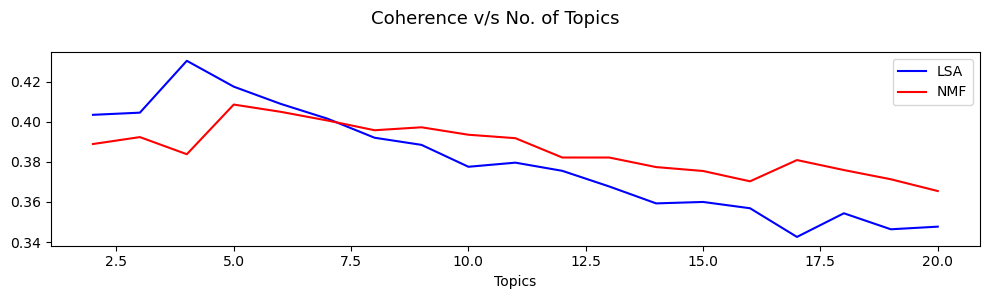

In [17]:
fig,ax = plt.subplots(figsize= (10,3))
sns.lineplot(data= results_df, x= "Topics", y= "LSA Coherence", ax= ax, color= "blue", label= "LSA")
sns.lineplot(data= results_df, x= "Topics", y= "NMF Coherence", ax= ax, color= "red", label= "NMF")
plt.legend()
ax.set_ylabel('')

plt.suptitle("Coherence v/s No. of Topics", fontsize= 13)
plt.tight_layout();
fig.savefig("images/coherence_lsa_nmf.png")

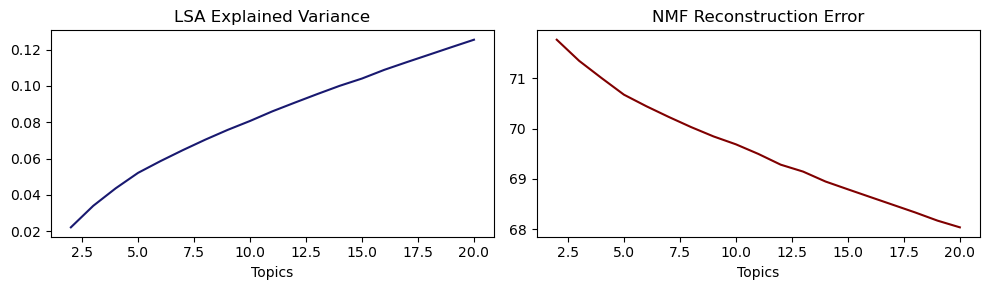

In [28]:
fig,axs = plt.subplots(figsize= (10,3), ncols= 2)
sns.lineplot(data= results_df, x= "Topics", y= "LSA Explained Variance", ax= axs[0], color= "midnightblue")
axs[0].set_title("LSA Explained Variance")
axs[0].set_ylabel('')

sns.lineplot(data= results_df, x= "Topics", y= "NMF Reconstruction Error", ax= axs[1], color= "maroon")
axs[1].set_title("NMF Reconstruction Error")
axs[1].set_ylabel('')

plt.tight_layout();
fig.savefig("images/lsa_nmf_error_variance.png")

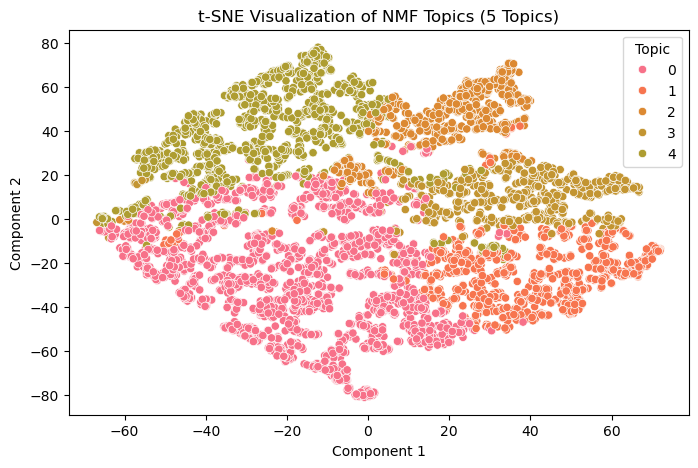

In [78]:
# Apply t-SNE to the LSA topic matrix
tsne = TSNE(n_components=2, random_state=0)
tsne_result = tsne.fit_transform(nmf_topics[5])

# Create a DataFrame for plotting
df_tsne = pd.DataFrame(tsne_result, columns=['Component 1', 'Component 2'])
df_tsne['Topic'] = np.argmax(nmf_topics[5], axis=1)

# Plotting
plt.figure(figsize=(8, 5))
palette = sns.color_palette("husl", n_topics)
sns.scatterplot(data=df_tsne, x='Component 1', y='Component 2', hue='Topic', palette=palette, legend='full')
plt.title('t-SNE Visualization of NMF Topics (5 Topics)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Topic')
plt.show()


In [42]:
# Define helper function to print and return top words
def get_topic_words(model, feature_names, n_words=10, print_words= False):
    topic_words = {}
    for topic_idx, topic in enumerate(model.components_):
        # words = [feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]
        # topic_words[f"Topic {topic_idx}"] = words

         # Get words and their weights
        word_weights = {feature_names[i]: topic[i] for i in range(len(feature_names))}
        # Sort words by their weights in descending order
        sorted_words = dict(sorted(word_weights.items(), key=lambda item: item[1], reverse=True))
        topic_words[f"Topic {topic_idx}"] = sorted_words

        # print if needed
        if print_words:
            message = "\nTopic # {}:\n".format(topic_idx)
            message += " ;".join([feature_names[i] for i in topic.argsort()[:-n_words - 1 :-1]])
            print(message)

    return topic_words

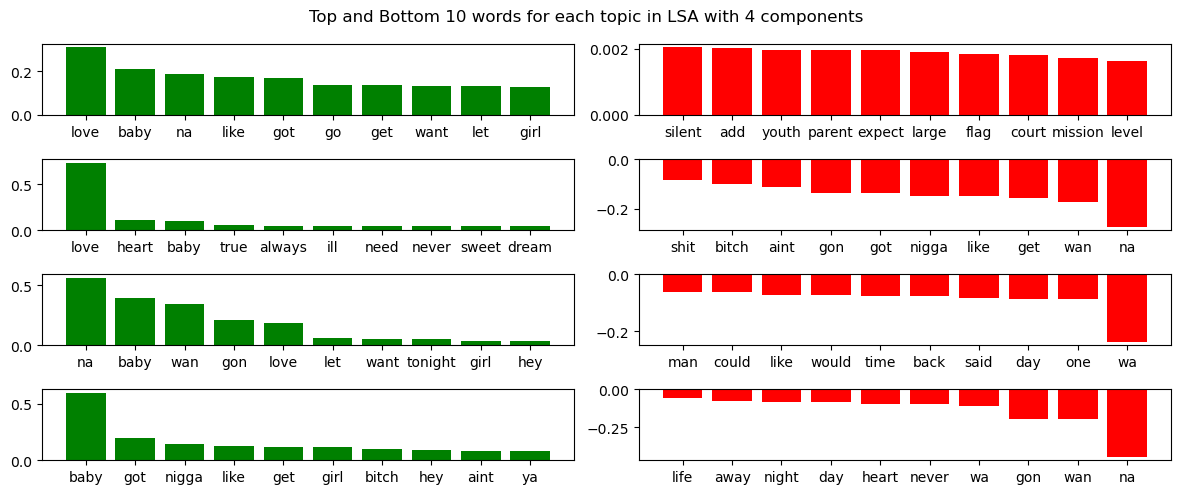

In [74]:
dt_lsa = get_topic_words(lsa_models[2], feature_names)

fig,axs = plt.subplots(figsize=(12,5), ncols= 2, nrows= 4)

ii = 0
for key,value in dt_lsa.items():
    tmp_dt = pd.DataFrame.from_dict(value, orient= "index")
    axs[ii,0].bar(tmp_dt.index[:10], height= tmp_dt.head(10)[0], color= "green")
    axs[ii,1].bar(tmp_dt.index[-10:], height= tmp_dt.tail(10)[0], color= "red")

    ii += 1

plt.suptitle("Top and Bottom 10 words for each topic in LSA with 4 components")
plt.tight_layout();
fig.savefig("images/lsa_10_words.png")